# Real-world driving logs

In this example a gyro is simulated from real-world vehicle sensor logs.

We use data from the [KITTI](https://www.cvlibs.net/datasets/kitti/) vision
benchmark.  KITTI data is widely used to evaluate autonomous driving
applications and consists of sensor data from a modified passenger vehicle
operating in urban and suburban environments.

## Load and visualize log data

We start with the KITTI odometry benchmark reference data.  This provides accurate
reference data for developers of camera and lidar based odometry methods.  We
use Sequence #7 as an example.  It consists of a single closed loop drive around
a residential neighborhood in Karlsruhe, Germany.

The pose (position and orientation) of a camera is provided.  As is standard in
computer vision applications the camera frame is oriented `x-axis` right,
`y-axis` down, `z-axis` forward with respect to the vehicle.  Because it is an
odometry application, a local coordinate system is used.  The initial pose of
the camera is defined as the identity and all subsequent poses are reported
relative to the first.

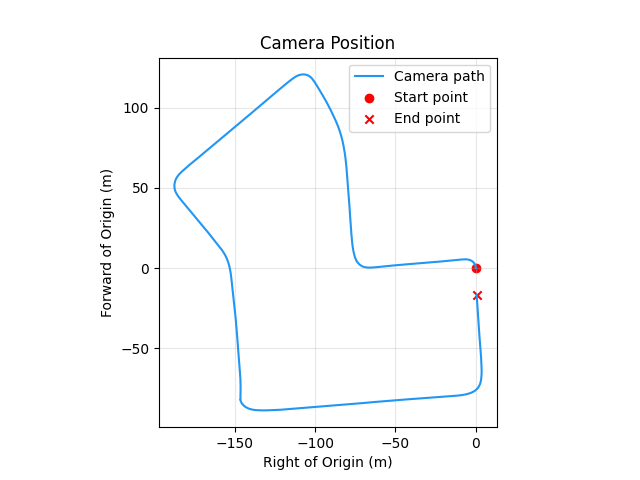

In [ ]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# This example is licensed under the CC BY-NC-SA 4.0 license.
# https://creativecommons.org/licenses/by-nc-sa/4.0/
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

from inertialsim import plot
from inertialsim.examples import kitti

odometry, inertial, calibration = kitti.load("kitti_data/", sequence=7)

cf_plot = plot.Scatter(
    title="Camera Position",
    xlabel="Right of Origin (m)",
    ylabel="Forward of Origin (m)",
)
cf_plot.line(odometry.pose[:, 0, 3], odometry.pose[:, 2, 3], color="#2196F3")
cf_plot.scatter(
    odometry.pose[0, 0, 3],
    odometry.pose[0, 2, 3],
    marker="o",
    color="red",
)
cf_plot.scatter(
    odometry.pose[-1, 0, 3],
    odometry.pose[-1, 2, 3],
    marker="x",
    color="red",
)
cf_plot.legend(["Camera path", "Start point", "End point"])

## Create the input data

The input to our simulated gyro is the vehicle motion.  In this case, since no
angular rate data is directly available, we use the odometry pose data instead.
It is supplied as a 4x4 transform matrix including rotation matrix and
translation vector components.

We extract the 3x3 rotation matrix and use it to initialize an InertialSim
[Rotation][inertialsim.geometry.Rotation] object.  We need to orthonormalize the
input matrix because KITTI data is stored in ASCII form with limited precision.

In [2]:
from inertialsim.geometry import Rotation

attitude = Rotation.from_matrix(
    odometry.pose[:, 0:3, 0:3],
    time=odometry.time,
    orthonormalize=True,
)

## Simulate an ideal gyro

We can now simulate an ideal gyro.  That is, an error-free gyro co-located and
aligned with the camera.

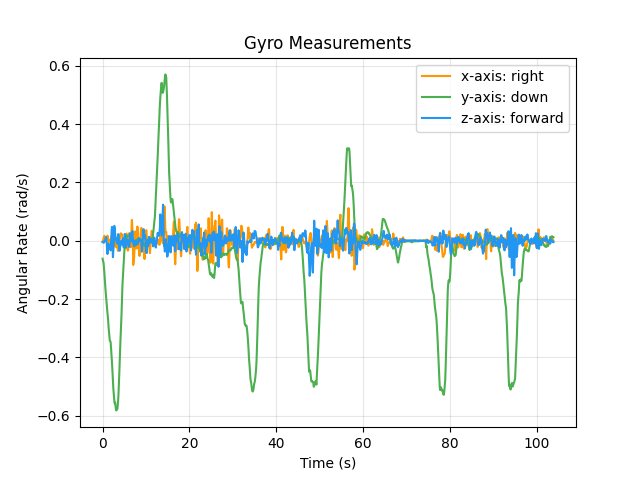

In [3]:
from inertialsim.sensors import SensorModel
from inertialsim.sensors.gyro import Gyro, GyroSpecification

perfect_gyro = GyroSpecification()
default_model = SensorModel()
gyro = Gyro(default_model, perfect_gyro, rng=0)
result = gyro.simulate(attitude=attitude)

cfg_plot = plot.TimeSeries(title="Gyro Measurements", ylabel="Angular Rate (rad/s)")
cfg_plot.line(result.angular_rate.time, result.angular_rate.data)
cfg_plot.legend(["x-axis: right", "y-axis: down", "z-axis: forward"])

As expected the signal is dominated by the `y-axis` rotation which correspond to
the car changing direction as it turns through corners.  The signal is quite
noisy due to the vibrations of the vehicle.

## Changing the gyro location

In this example, KITTI provides a calibration, in the form of a 4x4 transform
matrix between the camera and a reference INS.  We can simulate a gyro
co-located with the reference INS rather than one co-located with the camera.

Since all points on a rigid body experience the same angular rate, the
translation component does not affect gyro outputs.  Note that the same is not
true of accelerations.

We initialize another rotation matrix with the rotation component of the
calibration. We then use it to transform the attitude data so that it now
represents a rotation from the current INS frame to the initial INS frame
(rather than camera to camera as before).  The INS on the vehicle is mounted in
an `x-axis` forward, `y-axis` left, `z-axis` up convention (`FLU`).

Observe that the output looks similar to that above, except the signals are now
measured along different axes (Right, Down, Forward camera axes have been
transformed into Forward, Left, Up axes).

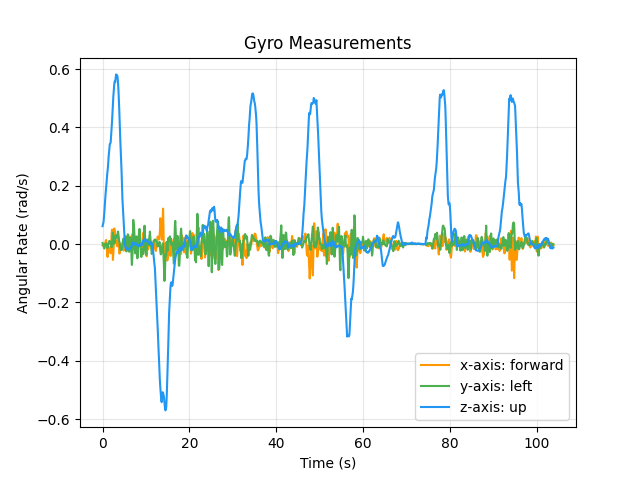

In [4]:
transform = Rotation.from_matrix(
    calibration.camera_to_ins[0:3, 0:3], orthonormalize=True
)
attitude_flu = transform @ attitude @ transform.inverse()
position_flu = transform.as_matrix() @ odometry.pose[:, 0:3, 3:4]

# In batch mode, running simulate() again will reset gyro state (with the
# exception of the random number generator).
result = gyro.simulate(attitude=attitude_flu)

ifg_plot = plot.TimeSeries(title="Gyro Measurements", ylabel="Angular Rate (rad/s)")
ifg_plot.line(
    result.angular_rate.time,
    result.angular_rate.data,
)
ifg_plot.legend(["x-axis: forward", "y-axis: left", "z-axis: up"])

## Simulate the effect of Earth's rotation

Gyros measure angular rate relative to inertial space.  In most applications,
pose and velocity are measured relative to Earth.  A perfectly accurate,
stationary gyro on Earth's surface will measure a 15 degree per hour rotation
rate that results from Earth's 24-hour rotation period in inertial space.
Simulating this signal may be relevant for long distance or long duration
applications with moderate accuracy sensors.

KITTI odometry data is measured relative to Earth (the stationary objects viewed
by the camera) and relative to it's start location (initial position and
orientation are arbitrary and set to identity).

In order to simulate the effects of Earth's rotation we need to input pose
relative to Earth (attitude and now also position since the surface level
components of Earth's rotation depend on latitude and longitude).

Returning to the KITTI data, we are able to set the vehicle's initial location
and orientation from the reference INS.  Note that this data may not always be
available or may be used more directly.  This procedure is used to demonstrate
the capabilities of InertialSim.

In [5]:
from inertialsim.geodesy import Coordinates, datums

# Rotate the odometry data into an East, North, Up (ENU) earth aligned frame
# using the initial INS attitude
ins_to_enu = Rotation.from_euler(inertial.attitude[0], sequence="XYZ")
attitude_enu = ins_to_enu @ attitude_flu
position_enu = ins_to_enu @ position_flu

initial_position = inertial.position[0]
origin = Coordinates.from_geodetic(initial_position)
datum = datums.TopocentricDatum(origin=origin, axis_order="ENU")

topocentric_position = Coordinates.from_topocentric(
    position_enu,
    datum,
    time=odometry.time,
)

## Analyzing the result

We can plot the transformed coordinates on a map to confirm they now accurately
represent global positions.

In [ ]:
global_plot = plot.MapOverlay("Topocentric Position")
lla = topocentric_position.as_geodetic()
global_plot.line(lla[:, 0], lla[:, 1])
# Uncomment for real-time interactive visualization
# global_plot.show()

--8<-- "docs/pages/examples/images/kitti_car_map.html"

## Simulate with Earth rate

Finally we can re-simulate with the new global inputs and the result will
include the effect of Earth's rotation.  Earth's rotation rate is approximately
`0.000048 rad/s` (`10 deg/h`) east and `0.000055 rad/s` (`11 deg/h`) north in
Karlsruhe.  This is imperceptible at the scale of the actual vehicle motion
(`0.1 - 0.6 rad/s`) but can be relevant when very high precision gyros are used;
in so-called *free inertial* navigation applications; or in long duration
applications.  

Below we plot the difference between the simulated gyro using
global inputs and the previous simulation with local pose inputs.  As expected
the earth rate signal is what remains.  It is primarily in the `z-axis` of the
sensor (up/vertical) with the north component projected along sensor `x-axis`
and `y-axis` depending on the direction of travel at any point in time.

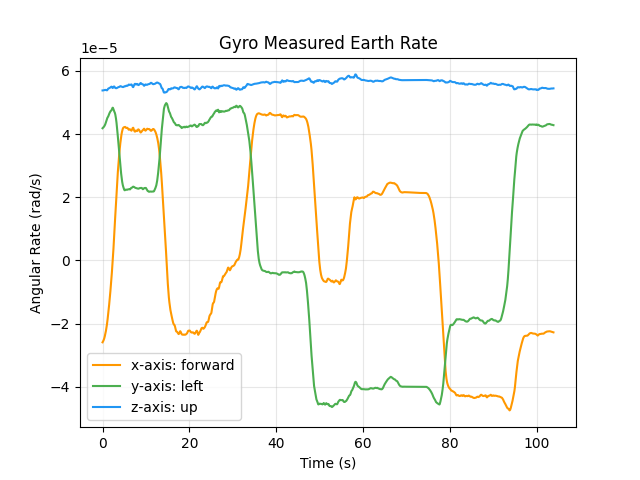

In [7]:
from inertialsim.geodesy import GlobalPose

pose = GlobalPose.from_topocentric(
    attitude=attitude_enu,
    position=topocentric_position,
    velocity=None,
    datum=datum,
)
pose.navigation_frame_rate()

# In batch mode, running simulate() again will reset gyro state (with the
# exception of the random number generator).
result_er = gyro.simulate(global_pose=pose)

gg_plot = plot.TimeSeries(
    title="Gyro Measured Earth Rate",
    ylabel="Angular Rate (rad/s)",
)
gg_plot.line(
    result.angular_rate.time, result_er.angular_rate.data - result.angular_rate.data
)
gg_plot.legend(["x-axis: forward", "y-axis: left", "z-axis: up"])